In [1]:
import pickle

import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from IPython.core.display import display
from IPython.display import Audio
import librosa

<h1>Waveform Generator</h1>

<p>One always has to make sure that they have enough data to feed the training process in order to sit down with a machine learning task. Lucky in this case, we can generate a huge handful of, admittedly stale sounding, waveforms to get the process started.</p><p>Some features of this generator will be to generate:</p>
<ul>
    <li>as many samples as need</li>
    <li>all samples of the same settable length and sample rate</li>
    <li>all four waveforms (sine, saw, square, and triangle)</li>
    <li>waveforms constructed with a random number of harmonics (Fourier Transform terms), when applicable</li>
    <li>random envelope shapes according to the traditional ADSR pattern (linear or exponential curves)</li>
    <li>different maximum and minimum amplitude profiles</li>
    <li>waveforms sounded with set pitches (set and controlled through MIDI numbers)</li>
    <li>a waveform and spectrogram plot of the resultant samples</li>
    <li>a listenable output function that enables hearing the waveforms in a Jupyter cell</li>
    <li>a float 1-D numpy array output, $d$ such that $d \in \mathbb{R}^{1 \times n}$ and $-1 \le d_{i} \le 1$</li>
    <li>the dataset output, including each waveform's features and the audio vector, as a pandas dataframe</li>
</ul>

In [2]:
#define basic expected constants
sampling_rate = 44100 / 2

#in seconds
length = 1

#possible output ranges of max sample amplitude
min_max = [0.5, 0.9]

#set of notes to generate
#C major scale above middle C include octave above
midi_notes = [60, 62, 64, 65, 67, 69, 71, 72]

#number of samples to generate for each of the
#above notes for each of the waveforms 
#(800 x len(midi_notes) x len(types_of_waveforms) 
size = 800

start_vars = [sampling_rate, length, min_max, midi_notes, size]

<p>Let's start by just building the constructor of our new generator class and bringing in all of the above attributes.</p>

In [3]:
class WaveGenny:
    
    def __init__(self, sampling_rate, length, 
                 min_max, midi_notes, size):
        self.sampling_rate = sampling_rate
        self.length = length
        self._min, self._max = min_max
        self.midi_notes = midi_notes
        self.size = size        

<p>The first order of business is to build a method that calculates the maximum harmonic number (or how many terms of the Fourier Transform) we can add before we start getting aliasing.</p>

<p>Recall that this value is dependent on the waveform we are generating.</p>
<h4><center>Sin and Saw</center></h4>
$$N  \lt \frac{f_{sr}}{2 \, f}$$
<h4><center>Square</center></h4>
$$N \lt \frac{f_{sr}}{4 \; f} + \frac{1}{2}$$
<h4><center>Triangle</center></h4>
$$N \lt \frac{f_{sr}}{4 \; f} - \frac{1}{2}$$

In [4]:
def get_max_harm(self, frequency, waveform):
    if waveform == 'sin':
        return 0
    elif waveform == 'saw':
        divisor = 1
        constant = 0
    elif waveform == 'squ':
        divisor = 2
        constant = 1 / 2
    #when waveform == 'tri'
    else:
        divisor = 2
        constant = - 1 / 2
    return int(self.sampling_rate / (divisor * frequency) + constant)

WaveGenny.get_max_harm = get_max_harm

<p>Up next, let's create a function that generates the blank time array, given the number of harmonics to include. If there aren't any harmonics included (say, when using a sine wave), just return the single time array.</p>

In [5]:
#Might not need frequency!!
def make_x(self, max_harm):
    x = np.linspace(0, self.length, int(self.sampling_rate * self.length), endpoint=False) 

    if max_harm < 1:
        output = x
    else:
        output = np.array([x for i in range(max_harm + 1)])
    return output

WaveGenny.make_x = make_x

<p>Here is a quick function to add random phase to the waveforms.</p>

In [6]:
def rand_phase(self):
    return np.random.uniform() 

WaveGenny.rand_phase = rand_phase

<p>Up next, let's create the waveform generator.</p>
<p>For this, we want to be able to generate a waveform of the desired type (sine, triange, saw, or square), frequency, maximum included harmonics (or, Fourier Transform terms), and whether or not to add random phase shifts.</p>

In [7]:
def gen_wave(self, frequency, max_harm, waveform, rand=None):
    y = self.make_x(max_harm)

    if rand:
        rand = rand
    else:
        rand = 0

    if waveform == 'sin':
        output = np.sin(2 * np.pi * frequency * (y + rand))

    elif waveform == 'saw':
        for i in range(1, y.shape[0] + 1):
            y[i - 1] = np.power(-1, i) * (np.sin(2 * np.pi * i * frequency * (y[i - 1] + rand))) / i
            
        output = - (2 / np.pi) * (np.sum(y, axis=0)) 

    elif waveform == 'squ':
        for i in range(1, y.shape[0] + 1):
            y[i - 1] = (np.sin(2 * np.pi * (2 * i - 1) * frequency * (y[i - 1] + rand))) / (2 * i - 1)
        
        output = (4 / np.pi) * (np.sum(y, axis=0)) 
    #waveform == 'tri'
    else:
        for i in range(y.shape[0]):
            y[i] = np.power(-1, i) * (np.sin(2 * np.pi * (2 * i + 1) * frequency * (y[i] + rand))) / np.power(2 * i + 1, 2)
        
        output = (8 / np.power(np.pi, 2)) * (np.sum(y, axis=0)) 

    return output

WaveGenny.gen_wave = gen_wave

<p>We have to now create an envelope generator for our waveforms.</p><p>We will use a traditional Attack-Decay-Sustain-Release (ASDR) model of sound envelopes.</p>

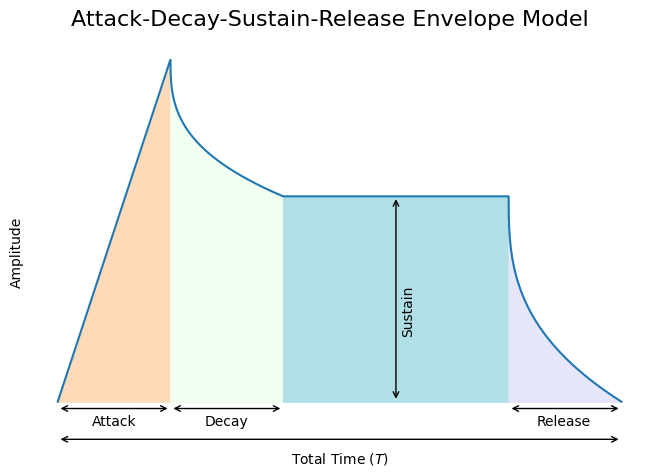

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

#This will be looked at later!!
def env_seg(time_seg, start_y, end_y, curve):
    x1, x2 = time_seg[0], time_seg[-1]
    y1, y2 = start_y, end_y
    output = (y2 - y1) * np.power((time_seg - x1) / (x2 - x1), curve) + y1
    return output

t = np.linspace(0, 1, 10000, endpoint=False) 
y = np.zeros(t.shape)

attack = 0.2
decay = 0.2
release = 0.2
sustain_amp = 0.6
sustain = 1 - (attack + decay + release)
rel_curve = 0.35

attack_seg = [0, int(t.shape[0] * attack)]
decay_seg = [attack_seg[1], attack_seg[1] + int(t.shape[0] * decay)]
sustain_seg = [decay_seg[1], decay_seg[1] + int(t.shape[0] * sustain)]
release_seg = [sustain_seg[1], t.shape[0]]



#Attack 
y[attack_seg[0]: attack_seg[1]] = env_seg(t[attack_seg[0]: attack_seg[1]], 0, 1, 1)
#Decay
y[decay_seg[0]: decay_seg[1]] = env_seg(t[decay_seg[0]: decay_seg[1]], 1, sustain_amp, rel_curve)
#Sustain
y[sustain_seg[0]: sustain_seg[1]] = env_seg(t[sustain_seg[0]: sustain_seg[1]], sustain_amp, sustain_amp, 1)
#Release
y[release_seg[0]: release_seg[1]] = env_seg(t[release_seg[0]: release_seg[1]], sustain_amp, 0, rel_curve)

ax.plot(t, y)

#Fill for attack
attack_color = 'peachpuff'
decay_color = 'honeydew'
sustain_color = 'powderblue'
release_color = 'lavender'
ax.fill_between(t[attack_seg[0]: attack_seg[1]], y[attack_seg[0]: attack_seg[1]], color=attack_color, alpha=1)
#Fill for decay
ax.fill_between(t[decay_seg[0]: decay_seg[1]], y[decay_seg[0]: decay_seg[1]], color=decay_color, alpha=1)
#Fill for sustain
ax.fill_between(t[sustain_seg[0]: sustain_seg[1]], y[sustain_seg[0]: sustain_seg[1]], color=sustain_color, alpha=1)
#Fill for release
ax.fill_between(t[release_seg[0]: release_seg[1]], y[release_seg[0]: release_seg[1]], color=release_color, alpha=1)

ax.set_ylim(-0.125, 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

for xlabel_i in ax.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in ax.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
for tick in ax.get_xticklines():
    tick.set_visible(False)
for tick in ax.get_yticklines():
    tick.set_visible(False)

#Total time arrow
ax.annotate("", xy=(0, -0.11), xytext=(1, -0.11),
            arrowprops=dict(arrowstyle="<->"))
#Attack time arrow
ax.annotate("", xy=(0, -0.02), xytext=(attack, -0.02),
            arrowprops=dict(arrowstyle="<->"))
#Decay time arrow
ax.annotate("", xy=(attack, -0.02), xytext=(attack + decay, -0.02),
            arrowprops=dict(arrowstyle="<->"))
#Release time arrow
ax.annotate("", xy=(attack + decay + sustain, -0.02), xytext=(1, -0.02),
            arrowprops=dict(arrowstyle="<->"))
#Sustain time arrow
ax.annotate("", xy=(attack + decay + sustain / 2, 0), xytext=(attack + decay + sustain / 2, sustain_amp),
            arrowprops=dict(arrowstyle="<->"))

ax.set_ylabel("Amplitude")
ax.set_xlabel("Total Time ($T$)")
fig.suptitle(r'Attack-Decay-Sustain-Release Envelope Model', fontsize=16)

ax.text(0.06, -0.07, r'Attack', fontsize=10, fontfamily=['DejaVu Sans'])
ax.text(0.06 + attack, -0.07, r'Decay', fontsize=10, fontfamily=['DejaVu Sans'])
ax.text(0.05 + attack + decay + sustain, -0.07, r'Release', fontsize=10, fontfamily=['DejaVu Sans'])
ax.text(0.01 + attack + decay + sustain / 2, sustain_amp / 2 - 0.1, r'Sustain', fontsize=10, fontfamily=['DejaVu Sans'], rotation='vertical')

plt.show()

<p>In the wild, the attack, decay, and release parameters ($attack_{t}$, $decay_{t}$, and $release_{t}$) are set in time (seconds or milliseconds). We, however, have an eye on normalized machine learning features and will define those three parameters, ($attack$, $decay$, and $release$) as ratios of the total time, $T$. That is:</p>
$$attack = \frac{attack_{t}}{T}$$
$$decay = \frac{decay_{t}}{T}$$
$$release = \frac{release_{t}}{T}$$
<p>The sustain length is then inferred as $1 - (attack + decay + release)$. </p>
<p>The sustain feature  is simply defined as the ratio of the sustain shelf amplitude to the maximum attack amplitude. The maximum attack amplitude for the envelope will always be set to $1$ and will be modulated to random levels later.</p>

<p>Notice that the attack segment is a straight line but the decay and release segments are negative exponential curves. We need to build a function that can create line segments of varying exponentiality (exponential -> linear -> logarithmic) between two points.</p>

<p>Below is an easy implementation that accepts two points, ($(x_{start}, y_{start})$, and $(x_{end}, y_{end})$), a curve parameter ($c$), and an input variable ($x$):</p>

$$\displaystyle y = (y_{end} - y_{start}) \left(\frac{x - x_{start}}{x_{end} - x_{start}}\right)^{c} + y_{start}$$

In [9]:
def env_seg(self, x, y1, y2, curve):
    x1, x2 = x[0], x[-1]
    output = (y2 - y1) * np.power((x - x1) / (x2 - x1), curve) + y1
    return output

WaveGenny.env_seg = env_seg

<p>The curver parameter is a bit tricky and dependent on whether the segment is increasing or decreasing.</p>

<p>If the line segment is increasing, $y_{end} \gt y_{start}$, and:</p>
<ul>
    <li>if $0 \lt c \lt 1$, then the segement will be logarithmic.</li>
    <li>if $c = 1$, then the segement will be linear.</li>
    <li>if $c \gt 1$, then the segment will be exponential.</li>
</ul>

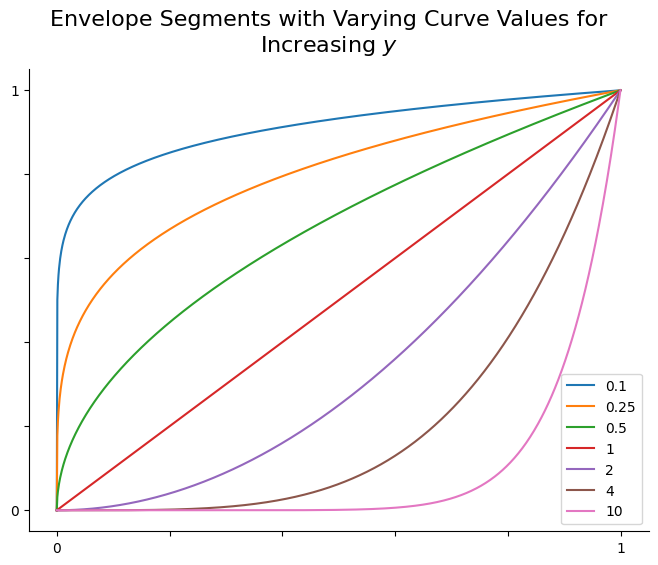

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

t = np.linspace(0, 1, 1000, endpoint=False) 
y1 = 0
y2 = 1

for curve in [0.1, 0.25, 0.5, 1, 2, 4, 10]:
    ax.plot(t, env_seg(None, t, y1, y2, curve), label=curve)
ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.suptitle('Envelope Segments with Varying Curve Values for\nIncreasing $y$', fontsize=16)

tick_dic = {'0.0': '0', '1.0': '1'}
ax.set_xticklabels([tick_dic.get(tick.get_text(), '') for tick in ax.get_xticklabels()])
ax.set_yticklabels([tick_dic.get(tick.get_text(), '') for tick in ax.get_yticklabels()])

plt.show()

<p>If the line segment is decreasing, $y_{end} \lt y_{start}$, and:</p>
<ul>
    <li>if $0 \lt c \lt 1$, then the segement will be exponential</li>
    <li>if $c = 1$, then the segement will be linear.</li>
    <li>if $c \gt 1$, then the segment will be logarithmic.</li>
</ul>

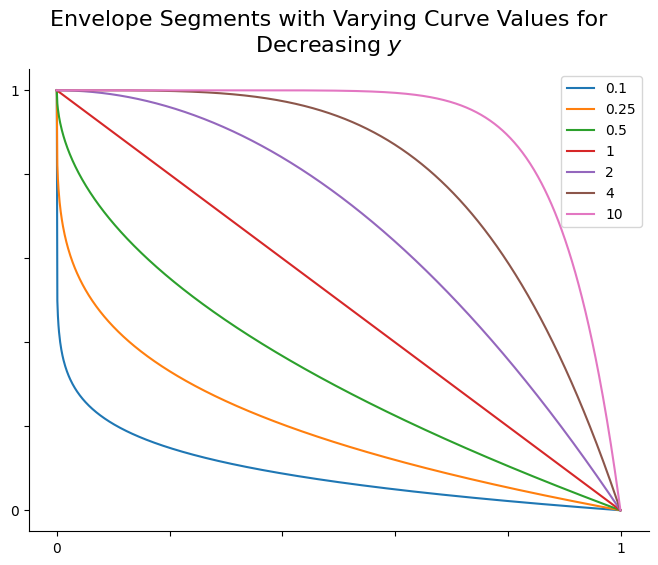

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

t = np.linspace(0, 1, 1000, endpoint=False) 
y1 = 1
y2 = 0

for curve in [0.1, 0.25, 0.5, 1, 2, 4, 10]:
    ax.plot(t, env_seg(None, t, y1, y2, curve), label=curve)
ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

tick_dic = {'0.0': '0', '1.0': '1'}
ax.set_xticklabels([tick_dic.get(tick.get_text(), '') for tick in ax.get_xticklabels()])
ax.set_yticklabels([tick_dic.get(tick.get_text(), '') for tick in ax.get_yticklabels()])

fig.suptitle('Envelope Segments with Varying Curve Values for\nDecreasing $y$', fontsize=16)

plt.show()

<p>We can now create a full ASDR function since we have a curved segment generator.</p>

In [12]:
def envelope(self, attack, att_curve, decay, dec_curve, sustain_amp, release, rel_curve):
    t = self.make_x(0)
    y = self.make_x(0)

    sustain = 1 - (attack + decay + release)
    attack_seg = [0, int(t.shape[0] * attack)]
    decay_seg = [attack_seg[1], attack_seg[1] + int(t.shape[0] * decay)]
    sustain_seg = [decay_seg[1], decay_seg[1] + int(t.shape[0] * sustain)]
    release_seg = [sustain_seg[1], t.shape[0]]

    #x, y1, y2, curve
    #Attack 
    y[attack_seg[0]: attack_seg[1]] = self.env_seg(y[attack_seg[0]: attack_seg[1]], 0, 1, att_curve)
    #Decay
    y[decay_seg[0]: decay_seg[1]] = self.env_seg(y[decay_seg[0]: decay_seg[1]], 1, sustain_amp, dec_curve)
    #Sustain
    y[sustain_seg[0]: sustain_seg[1]] = self.env_seg(y[sustain_seg[0]: sustain_seg[1]], sustain_amp, sustain_amp, 1)
    #Release
    y[release_seg[0]: release_seg[1]] = self.env_seg(y[release_seg[0]: release_seg[1]], sustain_amp, 0, rel_curve)

    return y

WaveGenny.envelope = envelope

<p>Huzzah! Then, we need to create a function that is going to multiply the waveform and the envelope. We also want to add the ability scale the total output.</p>

In [13]:
def create_waveform(self, frequency, adsr, waveform, max_harm, scale, rand=None):
    wave = self.gen_wave(frequency, max_harm, waveform, rand=rand)
    envelope = self.envelope(*adsr)
    output = np.multiply(wave, envelope)
    #The max sample amplitude needs to be searched for
    #across the +ves and -ves
    max_samp = np.abs(output).max()
    #0 + epsilon < scale < 1
    output = scale * (output / max_samp)
    output = np.asarray(output).astype('float32')
    return output

WaveGenny.create_waveform = create_waveform

<p>Almost done. The last step is to generate the dataset and shove it into a pandas DataFrame alongside all of the input features. We are looping over:</p>

<ul>
    <li>Waveforms</li>
    <li>Midi notes in the C Major scale above middle C</li>
    <li>Number of samples generated for each of the above</li>
</ul>

<p>We also need to set some boundaries and conditions for the following randomly generated parameters:</p>

<ul>
    <li>ADSR and curve parameters</li>
    <li>Max harmonics included </li>
    <li>Amplitude scaling</li>
</ul>

<p>There is an interesting hiccup when one sits down to sample curve parameter values. Simply asking for a random value between small fraction and large number would grotesquely oversample the $c \gt 1$ envelopes. Even if you consider a uniform random sampling of $1 \geq c \geq 20$, you would end up oversampling sharp envelopes: the difference, aurally and mathematically, between $c=10$ and $c=20$ is much, much smaller than the difference between $c=1$ and $c=10$.</p>

<p>My solution is to generate random samples, $X_{i}$, from a normal distribution, where $\mu = 0$, $\sigma = 4.5$ (note: the $\sigma$ is a Fermi guess), and;</p>

<p>if:</p>
$$X_{i} \geq 0$$
$$\implies c_{i} = X_{i} + 1$$
<p>and, if:</p>
$$X_{i} \lt 0$$
$$\implies c_{i} = \frac{1}{\lvert X_{i} \rvert + 1}$$

In [14]:
def rand_curve(self):
    mu, sigma = 0, 4.5 # mean and standard deviation
    x = np.random.normal(mu, sigma, 3)
    return np.where(x < 0, 1 / (np.abs(x) + 1), x + 1)

WaveGenny.rand_curve = rand_curve

In [15]:
def generate_dataset(self):
    df_columns = ['midi', 'freq', 'osc', 'scale',
                  'harm', 'rand', 'att', 'att_curve',
                  'dec', 'dec_curve', 'sus', 
                  'rel', 'rel_curve', 'sampling_rate', 
                  'length', 'audio']
    num_samples = 4 * len(self.midi_notes) * self.size
    
    self.df = pd.DataFrame(index=range(num_samples), columns=df_columns)

    #ADSR parameter boundaries
    min_att, max_att = 10, 30
    min_dec, max_dec = 10, 30
    min_sus, max_sus = 30, 100
    min_rel, max_rel = 10, 30

    index = 0
    for osc in ['sin', 'saw', 'squ', 'tri']:
        for note in self.midi_notes:
            for i in range(self.size):
                self.df.iloc[index]['osc'] = osc
                self.df.iloc[index]['att'] = np.random.randint(min_att, max_att) / 100
                self.df.iloc[index]['dec'] = np.random.randint(min_dec, max_dec) / 100
                self.df.iloc[index]['sus'] = np.random.randint(min_sus, max_sus) / 100
                self.df.iloc[index]['rel'] = np.random.randint(min_rel, max_rel) / 100
                #Curve parameters
                self.df.iloc[index]['att_curve'], self.df.iloc[index]['dec_curve'], self.df.iloc[index]['rel_curve'] = self.rand_curve()
                self.df.iloc[index]['freq'] = librosa.midi_to_hz(note)
                self.df.iloc[index]['length'] = self.length
                self.df.iloc[index]['sampling_rate'] = self.sampling_rate
                self.df.iloc[index]['midi'] = note

                #I am setting a minimum number of 
                #Fourier Transform terms to include get_max_harm(self, frequency, waveform)
                if (max_harm := self.get_max_harm(self.df.iloc[index]['freq'], self.df.iloc[index]['osc'])) <= (min_harm := 4):
                    self.df.iloc[index]['harm'] = max_harm
                else:
                    self.df.iloc[index]['harm'] = np.random.randint(4, max_harm)
                    
                adsr_curve = [self.df.iloc[index]['att'], 
                              self.df.iloc[index]['att_curve'], 
                              self.df.iloc[index]['dec'], 
                              self.df.iloc[index]['dec_curve'], 
                              self.df.iloc[index]['sus'], 
                              self.df.iloc[index]['rel'], 
                              self.df.iloc[index]['rel_curve']]
                self.df.iloc[index]['rand'] = self.rand_phase()
                self.df.iloc[index]['scale'] = np.random.random() * (min_max[1] - min_max[0]) + min_max[0]

                self.df.iloc[index]['audio'] = self.create_waveform(self.df.iloc[index]['freq'], 
                                                                    adsr_curve, 
                                                                    self.df.iloc[index]['osc'],
                                                                    self.df.iloc[index]['harm'], 
                                                                    self.df.iloc[index]['scale'], 
                                                                    rand=self.df.iloc[index]['rand'])

                index += 1  
    return self

def save_df(self, name):
    with open(name, 'wb') as handle:
        pickle.dump(self.df, handle)

WaveGenny.generate_dataset = generate_dataset
WaveGenny.save_df = save_df

<p>The last things to make are to audit the results of what we've done so far.</p>

<p>Let's start with a way to search our dataset for a variable number of search parameters and output a random result.</p>

In [16]:
def query_df(self, query):
    if query:
        search_conditions = [self.df[col] == param for col, param in query.items()]
        if len(query) <= 1:
            results = self.df[search_conditions[0]]
        else:
            results = self.df[np.logical_and(*search_conditions)]
    else:
        results = self.df
    results = results.sample(n=1)
    return results

WaveGenny.query_df = query_df

<p>Now, let's use the above query sampler to output a random audio sample as well as a spectroscope and spectrogram of the output.</p>

In [17]:
def listen(self, query=None):
    sample = self.query_df(query)['audio'].iloc[0]
    display(Audio(sample, rate=self.sampling_rate))

WaveGenny.listen = listen

In [18]:
def viz(self, query=None):
    result = self.query_df(query)
    frequency = result['freq'].iloc[0]
    length = result['length'].iloc[0]
    audio = result['audio'].iloc[0]
    sampling_rate = result['sampling_rate'].iloc[0]
    
    fig, (wave_ax, env_ax, spec_ax) = plt.subplots(1, 3, figsize=(18, 6))

    #Scope out the spectro-scope
    #hahaha, oh my
    #Display two periods of the waveform
    wave_time = np.linspace(0, (wave_dur := 2 / frequency), 
                            num=int(sampling_rate * wave_dur))
    index = wave_time.size
    wave_wave = self.gen_wave(frequency, 
                              result['harm'].iloc[0], 
                              result['osc'].iloc[0], 
                              rand=result['rand'].iloc[0])[:index]
    
    wave_ax.plot(wave_time, wave_wave)
    wave_ax.set_xlabel('Time (s)') 
    wave_ax.set_ylabel('Amplitude') 
    wave_ax.title.set_text('Waveform')

    wave_ax.spines['left'].set_position(('data', 1 / 440))
    wave_ax.spines['bottom'].set_position(('data', 0))
    wave_ax.spines['top'].set_visible(False)
    wave_ax.spines['right'].set_visible(False)

    wave_ax.xaxis.set_label_coords(0.9,0.55)
    wave_ax.set_xticks([x / 1760 for x in range(9)], labels=[r'$-\frac{}{}{}{}$'.format('{1}', '{', round(frequency), '}'), '', 
                                                             r'$-\frac{}{}{}{}$'.format('{1}', '{', round(frequency / 2), '}'), '', '', '', 
                                                             r'$\frac{}{}{}{}$'.format('{1}', '{', round(frequency / 2), '}'), '', 
                                                             r'$\frac{}{}{}{}$'.format('{1}', '{', round(frequency), '}')])
    
    wave_ax.set_yticklabels(['', '-1', '', r'-$\frac{1}{2}$', '','', '', r'$\frac{1}{2}$', '', '1', ''])
    wave_ax.yaxis.set_label_coords(0.45,0.8)
    
    frequency_handle = Line2D([0], [0], label='${} Hz$'.format(round(frequency)), color=wave_ax.get_lines()[0].get_color())
    wave_ax.legend(handles=[frequency_handle])

    #Next, the envelope!
    env_time = np.linspace(0, length, num=int(sampling_rate * length))

    env_ax.plot(env_time, audio)

    env_ax.spines['left'].set_visible(False)
    env_ax.spines['bottom'].set_visible(False)
    env_ax.spines['top'].set_visible(False)
    env_ax.spines['right'].set_visible(False)

    env_ax.title.set_text('Envelope')

    for xlabel_i in env_ax.get_xticklabels():
        xlabel_i.set_visible(False)
        xlabel_i.set_fontsize(0.0)
    for xlabel_i in env_ax.get_yticklabels():
        xlabel_i.set_fontsize(0.0)
        xlabel_i.set_visible(False)
    for tick in env_ax.get_xticklines():
        tick.set_visible(False)
    for tick in env_ax.get_yticklines():
        tick.set_visible(False)

    #Finally, the spectrogram
    D = librosa.stft(audio)#waveform_freq)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    #Hahaha, a few hours of frustrating graphing, I realized
    #Librosa's spechow defaults to using a sampling rate
    #of 22050 Hz
    img = librosa.display.specshow(S_db, y_axis='log', ax=spec_ax, sr=sampling_rate)
    fig.colorbar(img, ax=spec_ax, format="%+2.f dB")

    spec_ax.title.set_text('Spectrogram')
    
    plt.show()
    display(Audio(audio, rate=sampling_rate))

WaveGenny.viz = viz

In [33]:
wave = WaveGenny(*start_vars)
wave.sampling_rate = int(wave.sampling_rate / 2 / 2)
wave.size = int(wave.size / 2)
wave.generate_dataset().save_df('osc_dataset_5512.pickle')

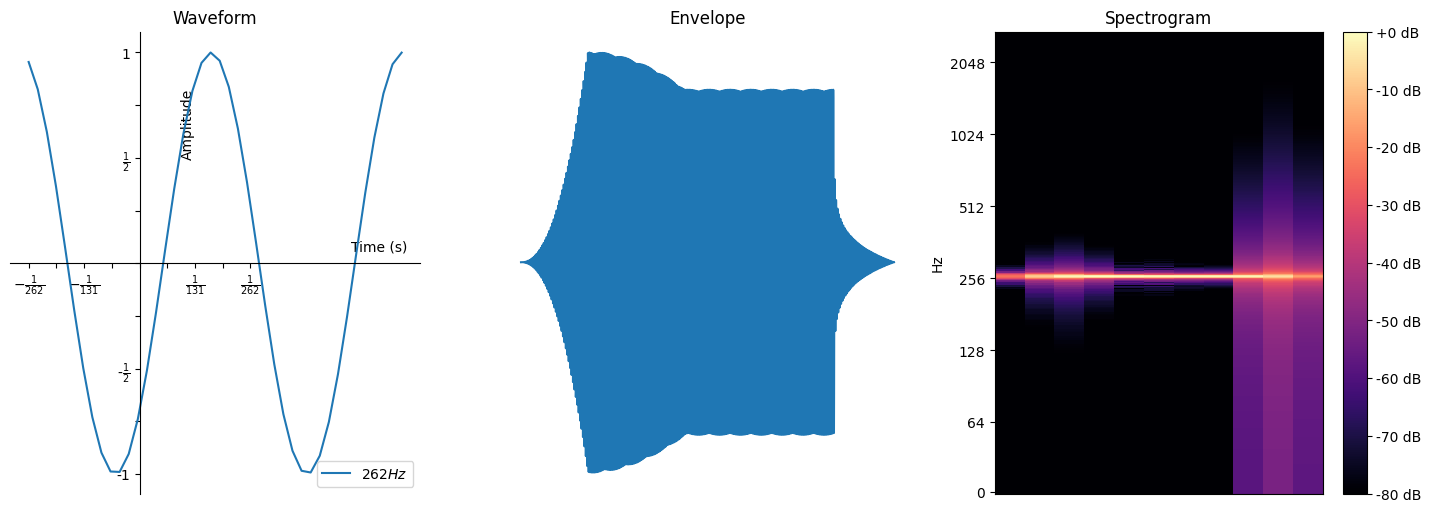

In [34]:
wave.viz(query={'osc': 'sin'})

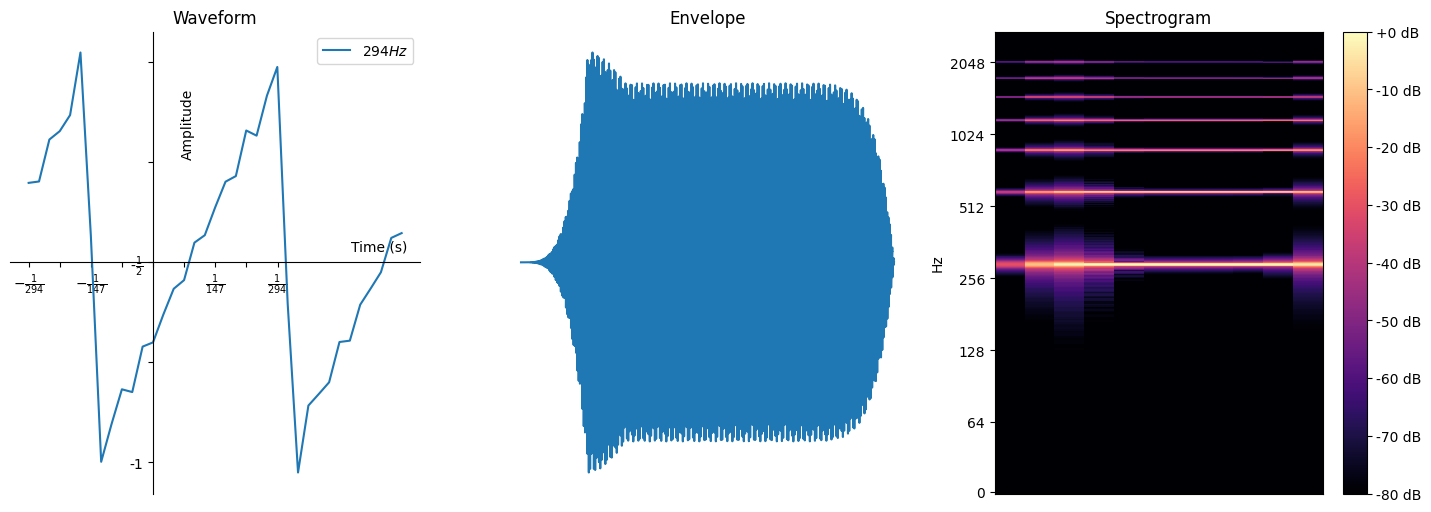

In [38]:
wave.viz(query={'osc': 'saw'})

In [36]:
wave.sampling_rate

5512

In [37]:
wave.df

,midi,freq,osc,scale,harm,rand,att,att_curve,dec,dec_curve,sus,rel,rel_curve,sampling_rate,length,audio
0,60,261.625565,sin,0.731263,0,0.967615,0.21,1.621806,0.27,2.758813,0.36,0.26,4.434529,5512,1,"[0.0, 7.499867e-06, 2.4253473e-05, 4.4941396e-..."
1,60,261.625565,sin,0.827551,0,0.746835,0.16,0.226598,0.14,2.497244,0.62,0.17,7.923746,5512,1,"[0.0, 0.06711247, 0.018348305, -0.047630887, -..."
2,60,261.625565,sin,0.813285,0,0.825318,0.19,0.162453,0.18,2.361768,0.8,0.28,4.013431,5512,1,"[-0.0, -0.046581738, 0.03527723, 0.12771523, 0..."
3,60,261.625565,sin,0.566132,0,0.734969,0.19,11.789733,0.2,0.17877,0.47,0.15,0.425072,5512,1,"[0.0, 1.2865247e-36, 3.5713013e-33, 2.707393e-..."
4,60,261.625565,sin,0.711906,0,0.244234,0.1,0.123079,0.16,0.421912,0.6,0.12,3.875072,5512,1,"[-0.0, -0.11096538, -0.016444251, 0.09398597, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12795,72,523.251131,tri,0.611251,4,0.184437,0.2,0.186723,0.25,0.191598,0.76,0.19,2.36004,5512,1,"[-0.0, -0.070687294, -0.15551269, -0.17947936,..."
12796,72,523.251131,tri,0.79022,4,0.223742,0.21,0.203452,0.23,3.324342,0.75,0.15,0.965037,5512,1,"[0.0, 0.13056912, 0.21367912, 0.13966057, 0.04..."
12797,72,523.251131,tri,0.783482,4,0.722361,0.22,7.294923,0.17,0.111711,0.41,0.23,0.663014,5512,1,"[-0.0, 7.501584e-24, 2.7583166e-21, 7.666312e-..."
12798,72,523.251131,tri,0.789096,4,0.149136,0.21,0.415038,0.21,0.642627,0.79,0.26,8.831832,5512,1,"[0.0, 0.023327585, 0.053986173, 0.049740363, 0..."
